### Project start.

To ensure that our project runs smoothly and that its dependencies do not conflict with other projects or system libraries, we first create a virtual environment for it.
Then, we install all the required dependencies and packages listed in the **requirements.txt**.

Once this is done, we proceed to import all the necessary libraries into our project.

In [1]:
import os
from dotenv import load_dotenv

import time
import collections
from typing import List, Dict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import nltk
from bs4 import BeautifulSoup
from wordcloud import WordCloud, ImageColorGenerator

from selenium import webdriver
from selenium.webdriver.common.keys import Keys

load_dotenv()

True

I opted to use the **Selenium** library for this task because the **Spotify** page with all the songs of the artist loads dynamically and requires a more robust tool than the lighter **Requests** library. With **Selenium**, I was able to easily navigate through the pages of the site and log in to access the desired data. To parse the obtained data, I used the **BeautifulSoup** library.

### Extracting titles and links to songs.

In [2]:
# Create a dictionary with page classes data.
page_classes = {"tracklist-row class" : "h4HgbO_Uu1JYg5UGANeQ",
                "div with name song"  : "standalone-ellipsis-one-line",
                "href class"          : "t_yrXoUO3qGsJS4Y6iXX"}

nicki_minaj_id = "0hCNtLu0JehylgoiP8L4Gh"

# We will parse data into this list.
data = []


def artist(
        page_classes: Dict[str, str],
        artist_id: str,
        data_storage: List[List]
        ):
    """A function for extracting titles and links to songs,
       and then writing the data to the list."""

    # Set up the Chrome webdriver, load page and give the page time to fully load.
    driver = webdriver.Chrome()
    url = "https://open.spotify.com/artist/" + artist_id + "/discography/all"
    driver.get(url)
    time.sleep(10)

    # Retrieve the page source and use BeautifulSoup to parse the HTML.
    html = driver.page_source
    soup = BeautifulSoup(html, "lxml")

    # Finding all the songs on a page.
    songs = soup.findAll("div", class_ = page_classes["tracklist-row class"])
    
    # Go through the list of songs, get their names and links and save to list.
    for song in songs:
        name = song.find("div", class_ = page_classes["div with name song"]).text
        link = ("https://open.spotify.com" +
                song.find("a", class_ = page_classes["href class"]).get('href'))
        data_storage.append([name, link]) 

    driver.quit()


artist(page_classes, nicki_minaj_id, data)

# Check the data list.
print(len(data))
print(data[0])

272
['Super Freaky Girl', 'https://open.spotify.com/track/5VWskY7pnj9WmVtaHwQ8nM']


### Lyrics retrieval.

In [3]:
username = os.getenv('client_username')
password = os.getenv('password')


def retrieve_lyrics(data: List[List]):
    """Lyrics retrieval function."""
    
    driver = webdriver.Chrome()
    url = "https://accounts.spotify.com/en/login"
    driver.get(url)

    # Log in to Spotify to retrieve lyrics.
    driver.find_element("id", "login-username").send_keys(username)
    input_pass = driver.find_element("id", "login-password")
    input_pass.send_keys(password)
    input_pass.send_keys(Keys.ENTER)

    time.sleep(6)

    for element in data:
        url = element[1]
        element.insert(2, '')

        driver.get(url)
        time.sleep(6)
        
        html = driver.page_source
        soup = BeautifulSoup(html, "lxml")
        strings = soup.findAll("p", class_="NAaJboGa8qckhNNQTKTn")
        
        # Add song words to 3 column in list of data.
        for string in strings:
            words = string.text
            element[2] = f'{element[2]} , {words}'

    driver.quit()


retrieve_lyrics(data)

print(data[0])

['Super Freaky Girl', 'https://open.spotify.com/track/5VWskY7pnj9WmVtaHwQ8nM', ' , She\'s alright , That girl\'s alright with me, yeah , Ayy-yo (hey, hey, hey, hey) , I can lick it, I can ride it while you slipping and sliding , I can do all them little tricks, and keep the dick up inside it , You can smack it, you can grip it, you can go down and kiss it , And every time he leave me \'lone, he always tell me he miss it , He want a F-R-E, A-K , F-R-E, A-K, A-K, A-K, A-K , E-A-K, F-R-E-A-K , Uh, okay, one thing about me, I\'m the baddest alive , He know the prettiest bitch didn\'t come until I arrive , I don\'t let bitches get to me, I fuck they man if they try , I got a princess face, a killer body, samurai mind , They can\'t be Nicki, they so stupid, I just laugh when they try , A thong bikini up my ass, I think I\'ll go for a dive , His ex bitch went up against me, but she didn\'t survive , On applications, I write "pressure" \'cause that\'s what I apply (brrr) , Pressure, applied, c

### Writing to a file using Pandas.

In [165]:
header = ['name', 'link', 'words']
df = pd.DataFrame(data, columns=header)
df.to_csv("nicki_minaj_songs.csv", sep=';', encoding='utf8')
df.head()

,name,link,words
0,Super Freaky Girl,https://open.spotify.com/track/5VWskY7pnj9WmVt...,", She's alright , That girl's alright with me..."
1,Super Freaky Girl (with JT & BIA feat. Katie G...,https://open.spotify.com/track/4d8BA8VjNeSOosv...,", She's alright (ayo) , That girl's alright w..."
2,Likkle Miss (with Skeng) - Remix,https://open.spotify.com/track/2NbcYqjmp3eCODW...,", What up, what up, represent for the Barbz e..."
3,Likkle Miss - THE FINE NINE REMIX,https://open.spotify.com/track/4EZGX61V7YTien6...,", Ayy, Nicki, ah we seh tight nooki and stiff..."
4,Roman's Revenge (feat. Eminem),https://open.spotify.com/track/1QbYbCM5zyEpUv2...,", I am not Jasmine, I am Aladdin , So far ahe..."


### Data cleansing.

We have completed the data extraction process and we have collected everything we need.

Let's get to the most interesting part. We will find out what our favorite singers sing about, and what words appear most often in their lyrics.

The algorithm will be the following:
1. *We will get all the lyrics from the extracted data and combine them into one string.*
2. *Then we cleanse the data from stop words. For the most popular words, we combine the singular and plural forms. For different singers, the data cleansing process may be different.*
3. *Next, we will count the number of each word that occurs in the line and then we display the rating of popular words.*
4. *However, to perceive information more easily, it is better to* **visualize** *it. To do so, we will use the* **Matplotlib** *and* **WordCloud** *libraries.*

In [ ]:
# download the list of English stop words from NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words_custom = set(["i'm", 'like', 'got', 'get'])

# Join the words of all the songs into a string and translate them into lowercase.
string_of_songs = df['words'].str.cat(sep=' ')
string_of_songs = string_of_songs.lower()

# Remove strings with Labels names and join singular and plural forms of some words.
string_of_songs = (string_of_songs
    .replace('cash money records inc.', '')
    .replace('republic records, a division of umg recordings, inc.', '')
    .replace('young money/cash money records', '')
    .replace('cash money records', '')
    .replace(',', '')
    .replace('?', '')
    .replace('!', '')
    .replace('bitches', 'b*tch')
    .replace('bitch', 'b*tch')
    .replace('niggas', 'n*gga')
    .replace('nigga', 'n*gga')
    .replace('fuck', 'f*ck'))

# Filter out the stop words from the list.
words_list = string_of_songs.split()
filtered_words = [word for word in words_list if word not in stop_words]
filtered_words = [word for word in filtered_words if word not in stop_words_custom]
filtered_words = [word for word in filtered_words if len(word) > 2]

### Data visualisation.

In [26]:
# Count the number of occurrences of each word using a Counter object.
word_count = collections.Counter(filtered_words)

# Convert the Counter object to a pandas DataFrame.
df_word_count = pd.DataFrame.from_dict(word_count, orient='index', columns=['count'])

# Sort by the 'count' column in descending order and pick top 100 words.
sorted_df = df_word_count.sort_values('count', ascending=False)
top_100_words = sorted_df.head(100)
top_100_words.head()

,count
b*tch,1150
know,845
ain't,817
n*gga,613
yeah,588


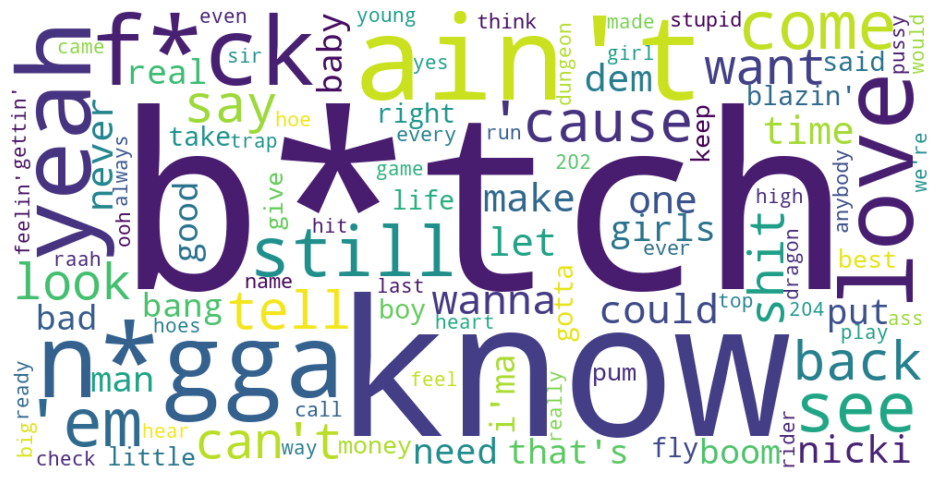

In [27]:
# Convert the DataFrame to a dictionary
word_dict = dict(zip(top_100_words.index, top_100_words['count']))

# Create a WordCloud object with the word frequencies
wc = WordCloud(background_color='white', width=1000, height=500).generate_from_frequencies(word_dict)

# Display the word cloud
plt.figure(figsize=(20, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

# store to file and show image
plt.savefig("word_cloud.png", format="png")
plt.show()

The information is already presented visually, showing the most commonly used words in Nicki Minaj's songs.
This allows us to form an opinion about her creativity.
Although we could stop here, I want to present the data in a way that immediately associates it with the singer's image.
To accomplish this, I will overlay a **mask** onto the word cloud, using either a pre-existing PNG file or creating one using Photoshop.
Once we have selected or created the mask image, we will use it to create the word cloud.
To ensure a cohesive color scheme, we will use the **ImageColorGenerator** function from the **WordCloud** library to map colors right before plotting the cloud.
We will then generate an image and save it as a file. 
---
The data looks more representative, and our work is done.

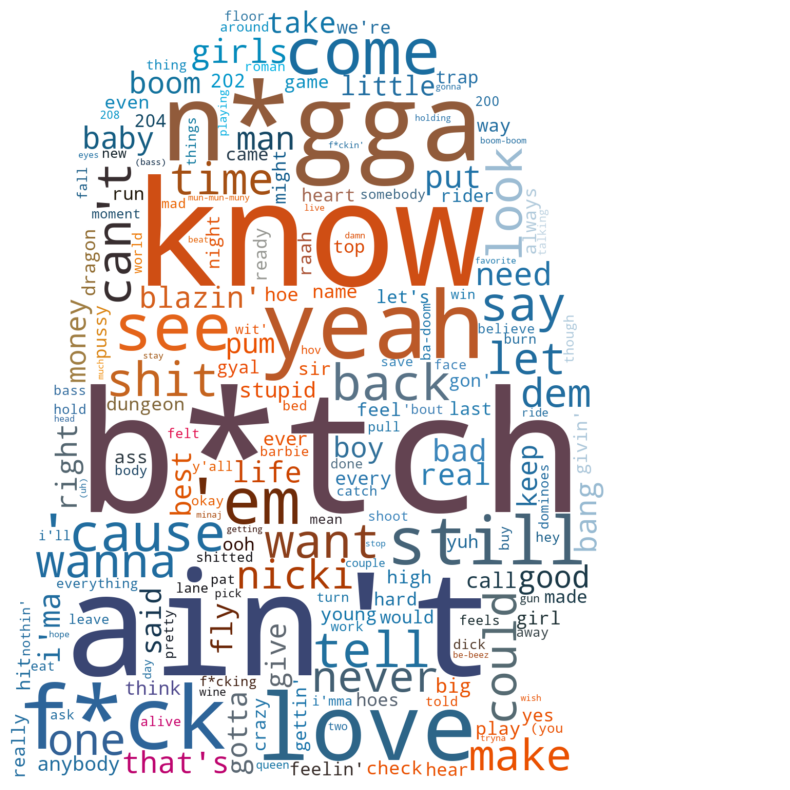

In [28]:
word_dict = dict(zip(sorted_df.index, sorted_df['count']))

# Generate a word cloud image
mask = np.array(Image.open("mask.jpg"))
wordcloud_mask = WordCloud(background_color="white", mode="RGBA", mask=mask).generate_from_frequencies(word_dict)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_mask.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

# store to file and show image
plt.savefig("wordcloud_mask.png", format="png")
plt.show()